In [1]:
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt
from scipy import linalg

%matplotlib notebook

from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:70% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))


image_folder = "../images/building2"
image_path = f"{image_folder}/base_undistorted.png"

# Single view metrology
The goal is to show how one can make measurements in an an image using simple projective geometry properties.
This is following the paper "Single View Metrology" of A.Criminisi, I.Reid and A.Zisserman (https://www.cs.cmu.edu/~ph/869/papers/Criminisi99.pdf)

## Remarks
- Here we use the vertical vanishing point as reference direction and we take one measurement in the world in order to get scale.
- Since we use vanishing points, the image needs to be undistorted.

# Figure
In this first part we work on this figure, where the distortion has already been corrected. It will be updated as cells are run.

<IPython.core.display.Javascript object>


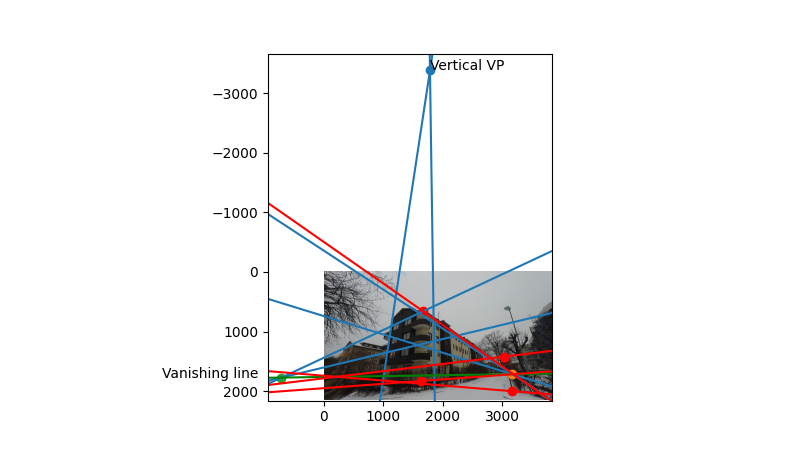

In [2]:
im = imread(f"{image_path}")
plt.figure(figsize=(16*0.5,9*0.5))
plt.imshow(im)

# Utility functions
For this project we need to deal with lines and points.
- Points are represented as coordinates (x, y), sometimes homogeneous as (x, y, w) if needed.
- Lines are represented either as a join of two points, or as the coefficients a, b, c of the line equation ax + by + c = 0. This representation allows us to easily compute lines intersection with the cross product. 

## Intersection of lines
For robustness' sake, we want to be able to compute the intersection in 2D of more than 2 lines. In general, such point does not exist so we compute the point that would minimise an error.
To do so we use least squares.

There are multiple ways to find the solution, in this case we use the general derivation described in https://en.wikipedia.org/wiki/Line%E2%80%93line_intersection#In_two_dimensions.
We define a line as a point and a unit direction vector. Then we can compute the distance from a point *p* to any line, and find  *p* that minimizes the sum of these distances.


In [3]:
def line_coeff_from_line_points(line):
    """
    Converts a point representation into a line equation representation:
    [(x1, y1), (x2, y2)] -> ax + by + c = 0
    """
    # Read https://en.wikipedia.org/wiki/Linear_equation
    x1, y1, x2, y2 = line.flatten()
    return (y1 - y2), (x2 - x1), (x1 * y2 - x2 * y1)

def intersect_lines_2d(lines):
    """
    See:
    https://en.wikipedia.org/wiki/Line%E2%80%93line_intersection#In_two_dimensions
    """
    # We define a line as (a, n) where 
    # a is a point on the line
    # n is the direction vector
    # We look for point p such that S * p = C
    S = np.zeros((2,2))
    C = np.zeros((2,))
    for line in lines:
        a = line[0]
        n = line[1] - line[0]
        n = n / np.linalg.norm(n)
        S += np.eye(2) - np.outer(n, n)
        C += (np.eye(2) - np.outer(n, n)) @ a
    
    return np.linalg.pinv(S) @ C.T

def test_intersection():
    # We define lines as (pt1, pt2) for convenience
    line1 = np.array([(0.,0.), (1., 1.)])
    line2 = np.array([(1, 0), (1, 1)])
    line3 = np.array([(0, 1), (1, 0.9)])

    lines = [line1, line2, line3]

    pt = intersect_lines_2d(lines)

    plt.figure(figsize=(6.5,6))

    for line in lines:
        plt.axline(line[0], line[1])

    plt.scatter(pt[0], pt[1])
    plt.show()
    
# Lesson to remember:
# Point to line distance
# To be learned:
# Cross product, dot product, inner product, outer product

# First method: measure the distance of a line from the ground
We will measure the height of the building. To do so we need:
- To identify the vertical vanishing point (as we are measuring in that direction)
- To identify the vanishing line (of the ground plane, ie plane orthogonal to the vertical vanishing point)
- To perform one heigh measurement in the vertical direction, to get the scale.

## First step: identifying vanishing points and lines
- We obtain the vertical vanishing point $v$ by intersecting vertical scene edges.

In [4]:
line1 = np.array([(1036, 1577), (1150, 824)])
line2 = np.array([(1860, 1597), (1849, 842)])
lines_vertical = [line1, line2]
v = intersect_lines_2d(lines_vertical)

for line in lines_vertical:
    plt.axline(line[0], line[1])
plt.scatter(*v)
plt.annotate("Vertical VP", v)

Text(1787.397411846998, -3386.1776414104133, 'Vertical VP')

- Then we know that images of lines parallel to the ground intersect at a point on the horizon line. We need at least two horizon points to compute the horizon line, so we pick two sets of scene lines: one on the right of the building and one on the left. We call those points $v_1$ and $v_2$.

In [5]:
# 2. A point v1 on the horizon is computed by intersecting edges on lines on the right side of the building
line1 = np.array([(1873, 866), (2366, 1189)])
line2 = np.array([(1808, 1297), (2376, 1472)])

lines_horizontal_right = [line1, line2]
v1 = intersect_lines_2d(lines_horizontal_right)

for line in lines_horizontal_right:
    plt.axline(line[0], line[1])
plt.scatter(*v1)

# 3. A second point v2 is computed by intersecting edges on lines on the left side of the building
line1 = np.array([(1462, 759), (1152, 904)])
line2 = np.array([(1420, 1266), (1085, 1346)])

lines_horizontal_left = [line1, line2]
v2 = intersect_lines_2d(lines_horizontal_left)

for line in lines_horizontal_left:
    plt.axline(line[0], line[1])
plt.scatter(*v2)

We can then compute the vanishing line $l$ by joining the two horizon points. $l = v_1 \times v_2$.

In [6]:
l = np.array([(v1), (v2)])
plt.axline(l[0], l[1], color="green")
plt.annotate("Vanishing line", v2, (v2[0] - 2000, v2[1]))

Text(-2708.7823343848722, 1774.3659305993751, 'Vanishing line')

### Second step: we select an horizontal line to measure
- We select a line parallel to the ground plane that we would like to measure. In our case we take the line define but the top of the stop signs.
- Then we compute its vanishing point by intersecting it with the vanishing line.

In [7]:
"""
Computes the vanishing point of a line, ie its intersection with the vanishing line
"""
def vanishing_point_of_line(line, vanishing_line):
    line_coeffs = line_coeff_from_line_points(line)
    vanishing_line_coeffs = line_coeff_from_line_points(vanishing_line)

    vp = np.cross(line_coeffs, vanishing_line_coeffs)
    vp = vp / vp[2]
    return vp

line_signs = np.array([(1985, 1548), top_of_sign := (3023, 1423)])
signs_vp = vanishing_point_of_line(line_signs, l)

- Now we define the image of the first line on the ground. Since they are parallel, they have the same vanishing point `sign_vp`. Thus we only need one more point on the ground to define it.

In [8]:
line_ground = np.array([bottom_of_sign := (3166, 2003), signs_vp[0:2]])

## Third step: perform the measurement
- We select a point on the first sign line, that's from where we want to measure. Then we get it's image on the ground line by projecting it.
- Note: here we simply reuse the same point on top of the sign that we used to define the line.
- Then we can finally use equation () to compute the distance between these two points.

These steps are done in sequence in function `get_distance`.

In [9]:
# 7. We select a point on the first line (here it we pick one of the points that was used to define the line)
def point_onto_line(point, line, vertical_vp):
    """
    Projects a point on a line into a parallel line.
    To do so:
    - we compute the line l that passes through this point and the vertical vanishing point using point X vertical_vp
    - then we intersect it onto the line using the l X line
    Where X is the cross product.
    
    Arguments:
    - point the point to project
    - line the line onto which we project
    
    Note: we assume line is orthogonal to vertical_vp, ie it is the horizon line.
    """
    point = (*point, 1)
    # We compute its projection on the second line
    point_on_line_projected = np.cross(np.cross(point, (*vertical_vp, 1)), line_coeff_from_line_points(line))
    point_on_line_projected = point_on_line_projected / point_on_line_projected[2]
    return point_on_line_projected[0:2]


def distance_from_points_on_lines(xp, x, vanishing_line, vertical_vp):
    """
    Computes the distance aZ from equation (10) of the paper. See folder "math" for 
    how to find this formula.
    Of course vertical_vp and vanishing_line are also respectively the third and fourth
    column of the projection matrix.
    
    Note: x has to be on the ground (in world coordinates, Z = 0) for the math to hold.
    """
    x = (*x, 1)
    xp = (*xp, 1)
    num = np.linalg.norm(np.cross(x, xp))
                         
    vanishing_line_coeffs = line_coeff_from_line_points(vanishing_line)
    I = vanishing_line_coeffs/np.linalg.norm(vanishing_line_coeffs)
    den1 = np.dot(I, x)
    den2 = np.linalg.norm(np.cross(xp, (*vertical_vp, 1)))
    
    aZ = -num / (den1 * den2)
    return aZ

In [10]:
"""
Computes the distance of between two lines at a given point, up to a scale.
Note: since the lines are parallel we will get the same result for any point on the lane.
A more practical way is described later.
"""
def get_distance(line1, line2, point_on_line_1, vertical_vp, vanishing_line):
    # In practice we want to compute the distance between 2 points.
    # So we project the point 1 into the second line (the line on the ground)
    point_on_line_2 = point_onto_line(point_on_line_1, line2, vertical_vp)
    
    plt.scatter(*point_on_line_1[0:2], color = "red")
    plt.scatter(*point_on_line_2[0:2], color = "red")
    plt.axline(line1[0], line1[1], color = "red")
    plt.axline(line2[0], line2[1], color = "red")
    
    return distance_from_points_on_lines(point_on_line_1, 
                              point_on_line_2,
                              vanishing_line,
                              vertical_vp)

line_ground = np.array([bottom_of_sign := (3166, 2003), signs_vp[0:2]])
dist_sign = get_distance(line_signs, line_ground, top_of_sign, v, l)
dist_sign

0.7442410648385962

## Fourth step: correct / get the scale
The distance we obtain is of the form $\alpha Z$ where $Z$ is the real world height. Therefore, we go outside and measure the height $Zr$ of the sign. We find $Z_r = 232$ cm.

Thus, from $\alpha Z = 232$ we compute the scale factor $\alpha$. Then we can use it to perform other measurements.

In [11]:
Zr = 232
alpha = dist_sign/Zr

## Fifth step: new measurement
Now we can perform new measurement. All we need are two points: one for the top of the line and one for the bottom (ground).
Here we mesaure the height of the roof from the ground, and retrieve the scale using $\alpha$.

In [12]:
# Make another measurement somewhere else. v = vertical vanishing point, l = horizontal vanishing line.
line_roof = np.array([top_of_roof := (1674, 661), (2455, 1206)])
roof_vp = vanishing_point_of_line(line_roof, l)
line_ground = np.array([bottom_of_building := (1876, 1814), roof_vp[0:2]])
dist_roof = get_distance(line_roof, line_ground, top_of_roof, v, l)
height = dist_roof/alpha
print(f"Roof height: {height:.1f} cm")

Roof height: 1738.7 cm


In [13]:
plt.show() # finish plotting

# Computing the distance between parallel planes
Before, we measured the height of a line from the ground. Now we want to compute distances between parallel planes, not necessarily on the ground.
We still use scale information derived from the vanishing points, but this time we also use properties of the projection matrix $P$ to make computations easier.

$P$ is the projection matrix define with respect to the reference (ground plane) $p$.
We define a new plane $p'$ parallel to $p$ separated with distance $Z_r$ that must be known.

- Note: with this method, we still need to compute $\alpha$ once, in the same way as before.

## First step: identifying vanishing points and lines

<IPython.core.display.Javascript object>


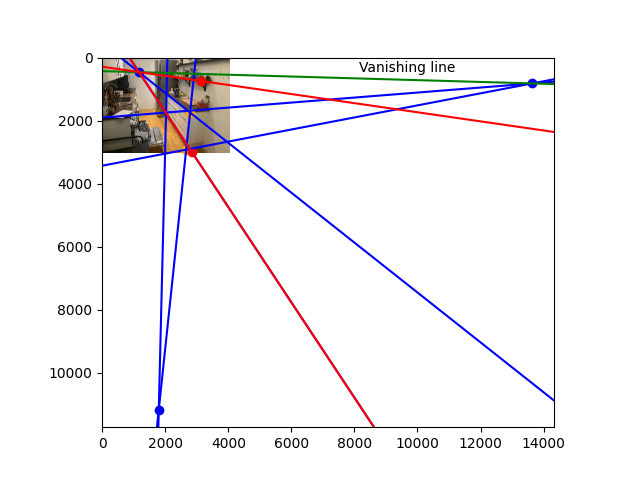

Text(8141.394190871462, 448.7868257261289, 'Vanishing line')

In [14]:

im = imread(f"../images/kitchen/kitchen.jpg")

plt.figure()
plt.imshow(im)

# 1. Obtain vertical vanishing point v by intersecting vertical scene edges
line1 = np.array([(2024, 1759), (2036, 1270)])
line2 = np.array([(2680, 2750), (2786, 1744)])
lines = [line1, line2]
Z_vp = intersect_lines_2d(lines)

for line in lines:
    plt.axline(line[0], line[1], color = "blue")
plt.scatter(*Z_vp, color = "blue")

# X vanishing point using windows on the right side
line1 = np.array([(2727, 2907), (3119, 2832)])
line2 = np.array([(2777, 1683), (3393, 1634)])
lines = [line1, line2]
X_vp = intersect_lines_2d(lines)

for line in lines:
    plt.axline(line[0], line[1], color = "blue")
plt.scatter(*X_vp, color = "blue")

# Y vanishing point using windows on the right side
line1 = np.array([(2024, 1759), ground_corner := (2680, 2750)])
line2 = np.array([(2039, 1153), top_corner := (2786, 1744)])
lines = [line1, line2]
Y_vp = intersect_lines_2d(lines)

for line in lines:
    plt.axline(line[0], line[1], color = "blue")
plt.scatter(*Y_vp, color = "blue")

vanishing_line = np.array([(X_vp), (Y_vp)])
plt.axline(*vanishing_line, color = "green")
plt.annotate("Vanishing line", X_vp, (X_vp[0] - 5500, X_vp[1] - 370))

# Second step: computing scale in the reference direction
We make a real world measurement using the counter: it is $Z_r$ = 85 cm high. We use this information to compute the vertical scale.

In [15]:
vanishing_line_coeffs = line_coeff_from_line_points(vanishing_line)
I = vanishing_line_coeffs/np.linalg.norm(vanishing_line_coeffs)

# So we choose pp as the top of the counter. Thus Zr = 85cm as measured.
# We want to measure the height of the shelf
# First we compute alpha like last time
actual_ground_corner = (2665, 2921)
plt.scatter(*top_corner, color = "orange")
plt.scatter(*actual_ground_corner, color = "orange")

aZ = distance_from_points_on_lines(xp = top_corner,
                              x = actual_ground_corner,
                              vanishing_line=vanishing_line,
                              vertical_vp = Z_vp)


Zr = 85
alpha = aZ / Zr

As a sanity check, we use the scale to compute the height of the shelf from the ground.

In [16]:
point_shelf = np.array([3146, 744])
line_shelf = np.array([point_shelf, (2218,610)])
line_ground = np.array([(2024, 1759), ground_corner := (2680, 2750)])
dist_shelf = get_distance(line_shelf, line_ground, point_shelf, Z_vp, vanishing_line)
shelf_height_from_ground = dist_shelf/alpha
print(f"Shelf height: {shelf_height_from_ground:.2f} cm")

Shelf height: 143.21 cm


# Third step: computing the projection matrix
The first three columns of the projection matrix $P$ are the vanishing points, up to scale. 
Following https://dl.acm.org/doi/10.1007/s11042-016-3904-2,
if $P_1, P_2, P_3$, are the vanishing points (with $P_i = [u_i, v_i, 1]$), then $P = [\lambda_1 P_1 \; \lambda_2 P_2 \; \lambda_3 P_3 \; P_4]$.

In our case, since we only measured the scale in the vertical direction, $P_1$ and $P_2$ are ill-defined. This is not an issue as they are not needed to measure in the vertical direction.

In [17]:
P = np.vstack([(*X_vp,0), (*Y_vp,0), (*alpha * Z_vp, alpha), I]).T

We can now use $P$ to directly compute the distance between two planes parallel to the ground, each defined by a point. To do so we use equation (14). The equation is very similar to the one used in `distance_from_points_on_lines`, except that this time the scale factor $\rho$ is not $x \cdot \dot l$, as the origin of the coordinate system we now use it not located on the ground anymore. 

Explanation:


$P_4$ represents the origin of the world coordinate system. Until now, we used $P_4 = \dot l$ for $P$ as the world coordinate system was anchored on the ground. However if we shift that coordinate system up or down, then $P_4$ changes to reflect that, with $P_4' = Z_r P_3 + P_4$ used to define a new projection matrix $P'$.

The equation used in `compute_Zp` is found in the same way as in `distance_from_points_on_lines`, but this time using $P'$, as we want to compute a distance *from the origin of $P'$* instead of from the ground, ie the origin of $P$.

In [18]:
def compute_Zp(xp, xpp, P, Zr):
    p3 = P[:,2]
    p4 = P[:,3]
    phi = (np.dot(xp, p4)) / (1 + np.dot(Zr * p3, p4))
    
    num = np.linalg.norm(np.cross(xp, xpp))
    den = phi * np.linalg.norm(np.cross(p3, xpp))
    
    return -num/den

shelf_distance_from_counter = compute_Zp((*top_corner, 1), (*point_shelf, 1), P, Zr)
print(f"Shelf distance from counter: {shelf_distance_from_counter:.1f} cm")
print(f"Shelf distance from counter (sanity check): {shelf_height_from_ground - Zr:.1f} cm")

Shelf distance from counter: 60.3 cm
Shelf distance from counter (sanity check): 58.2 cm


In [19]:
# Bonus: By knowing that PC = 0, we can determine the height of the camera center C.
aZc = - 1 / (np.dot(I, (*Z_vp,0)))
print(f"Height of the camera: {aZc/alpha:.1f} cm")

Height of the camera: 148.2 cm
